In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Nesse trabalho, utilizamos um dataset do kaggle: https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview

O objetivo do trabalho, é elaborar um modelo preditivo que seja capaz de prever a duração de uma viagem de taxi na cidade de Nova Iorque utilizando dados com as seguintes caracteristicas:

id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and 

forward; N=not a store and forward trip

trip_duration - duration of the trip in seconds

In [2]:
train = pd.read_csv('train.csv', parse_dates=['pickup_datetime'])
test = pd.read_csv('test.csv', parse_dates=['pickup_datetime'])

Vamos primeiramente realizar uma analise exploratoria dos dados, como vamos ver a seguir, nossos dados nao possuem valores nulos, portanto nossa preocupação não será tratar de dados faltantes.
Contudo, nosso desafio será enriquecer esses dados para que tenhamos uma maior precisão com nosso modelo preditivo e para isso, vamos precisar remover possiveis outliers e extrair algumas informações mais relevantes para que possamos fornecer para o modelo.

In [3]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


É possivel notar alguns problemas na coluna trip_duration a partir dos valores maximos dela, portanto, vamos verificar se existem outliers nela.

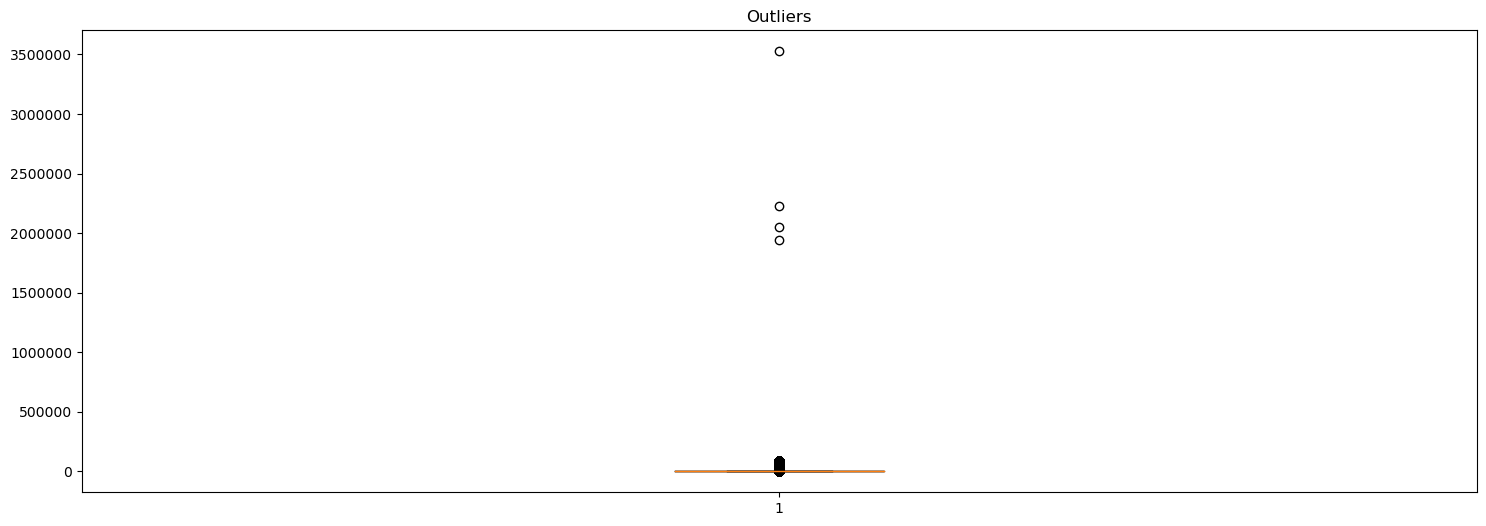

In [4]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.title("Outliers")

plt.boxplot(train['trip_duration'])
plt.ticklabel_format(style='plain', axis='y')


plt.show()

In [5]:
q = train.trip_duration.quantile(0.99)
train = train[train.trip_duration < q]

Como vimos, haviam outliers que podiam prejudicar nosso modelo na coluna trip_durations.
Agora vamos verificar como esses valores estão distribuidos.

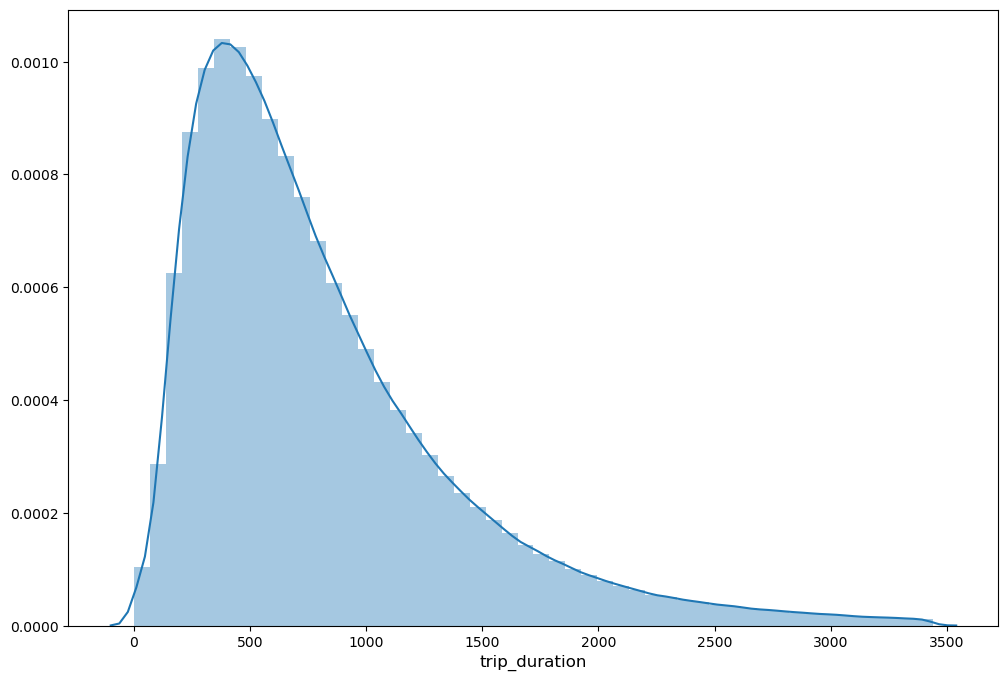

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train.trip_duration.values, bins=50, kde=True)
plt.xlabel('trip_duration', fontsize=12)
plt.show()

Como podemos ver, esses dados estão distribuidos de maneira assimetrica, uma forma de mitigar esse problema é através de uma transformação logaritmica
Assim, vamos ter valores distribuidos simetricamente, o que é interessante quando estamos pensando em treinar um modelo.

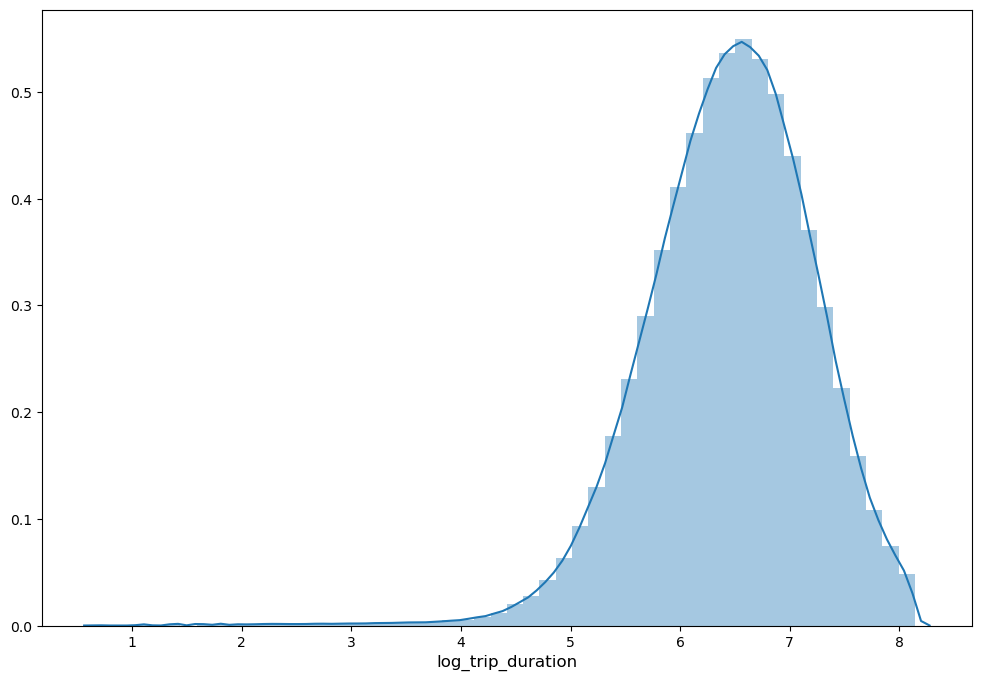

In [7]:
train = train.assign(log_trip_duration = np.log(train.trip_duration+1))
plt.figure(figsize=(12,8))
sns.distplot(train.log_trip_duration.values, bins=50, kde=True)
plt.xlabel('log_trip_duration', fontsize=12)
plt.show()

Como podemos ver, temos uma distribuição mais simetrica através da transformação logaritmica, essa distribuição inclusive se aproxima muito a distribuição normal.

Agora vamos remover possiveis outliers na quantidade de passageiros, é natural removermos viagens que não tiveram passageiros registrados.

In [8]:
train = train[(train.passenger_count > 0)]

Vamos analisar agora possiveis outliers nas colunas de geolocalização e remove-los se houver necessidade.

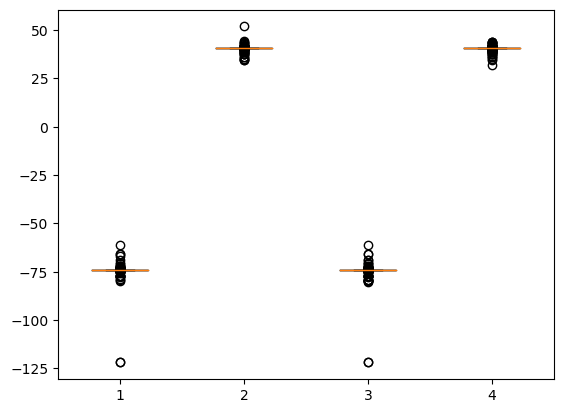

In [9]:
train_geo = [train['pickup_longitude'], train['pickup_latitude'], train['dropoff_longitude'], train['dropoff_latitude']]
fig, ax = plt.subplots()
ax.boxplot(train_geo)
plt.show()

In [10]:
train = train[(train.pickup_longitude < -70) & (train.pickup_longitude > -80)]
train = train[(train.pickup_latitude < 50)]
train = train[(train.dropoff_longitude < -70) & (train.dropoff_longitude > -80)]
train = train[(train.dropoff_latitude < 50)]

train = train[(train.passenger_count > 0)]

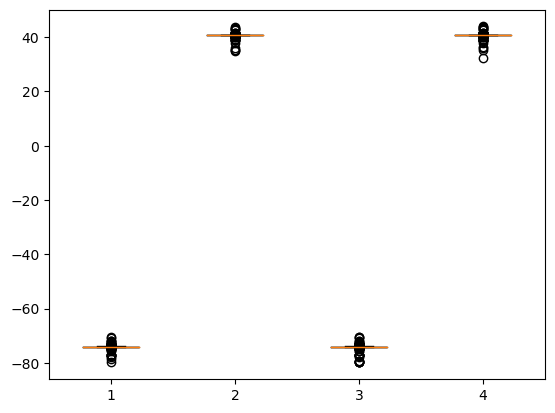

In [11]:
train_geo = [train['pickup_longitude'], train['pickup_latitude'], train['dropoff_longitude'], train['dropoff_latitude']]
fig, ax = plt.subplots()
ax.boxplot(train_geo)
plt.show()

Agora que removemos os outliers de localização, vamos criar algumas features para que possamos identificar outros outliers e também que vão ser valiosas para o treinamento do modelo.

Vamos criar uma coluna que representa a distancia radial entre um ponto e outro no globo através da função haversine.
Utilizaremos outra função para criar uma coluna que representa a direção da viagem

e por fim, vamos criar uma coluna de velocidade média, já que sabemos que distancia/tempo representa a velocidade e com essa coluna podemos identificar alguns outros outliers que podem ser prejudiciais ao nosso modelo.

In [12]:


def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


train['distance'] = ft_haversine_distance(train['pickup_latitude'].values,
                                                 train['pickup_longitude'].values, 
                                                 train['dropoff_latitude'].values,
                                                 train['dropoff_longitude'].values)

test['distance'] = ft_haversine_distance(test['pickup_latitude'].values,
                                                 test['pickup_longitude'].values, 
                                                 test['dropoff_latitude'].values,
                                                 test['dropoff_longitude'].values)

In [13]:

def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['direction'] = ft_degree(train['pickup_latitude'].values,
                                train['pickup_longitude'].values,
                                train['dropoff_latitude'].values,
                                train['dropoff_longitude'].values)

test['direction'] = ft_degree(test['pickup_latitude'].values,
                                test['pickup_longitude'].values,
                                test['dropoff_latitude'].values,
                                test['dropoff_longitude'].values)                                

In [14]:

train['kph'] = (train.distance / train.trip_duration)*3600

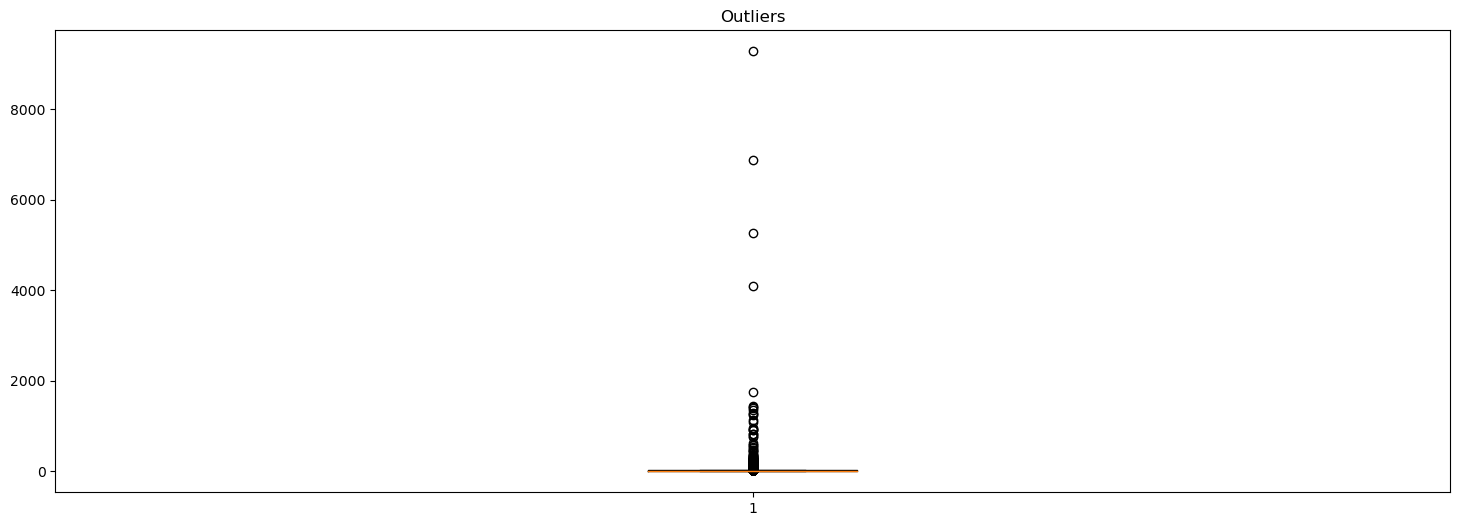

In [15]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.title("Outliers")

plt.boxplot(train['kph'])
plt.ticklabel_format(style='plain', axis='y')


plt.show()

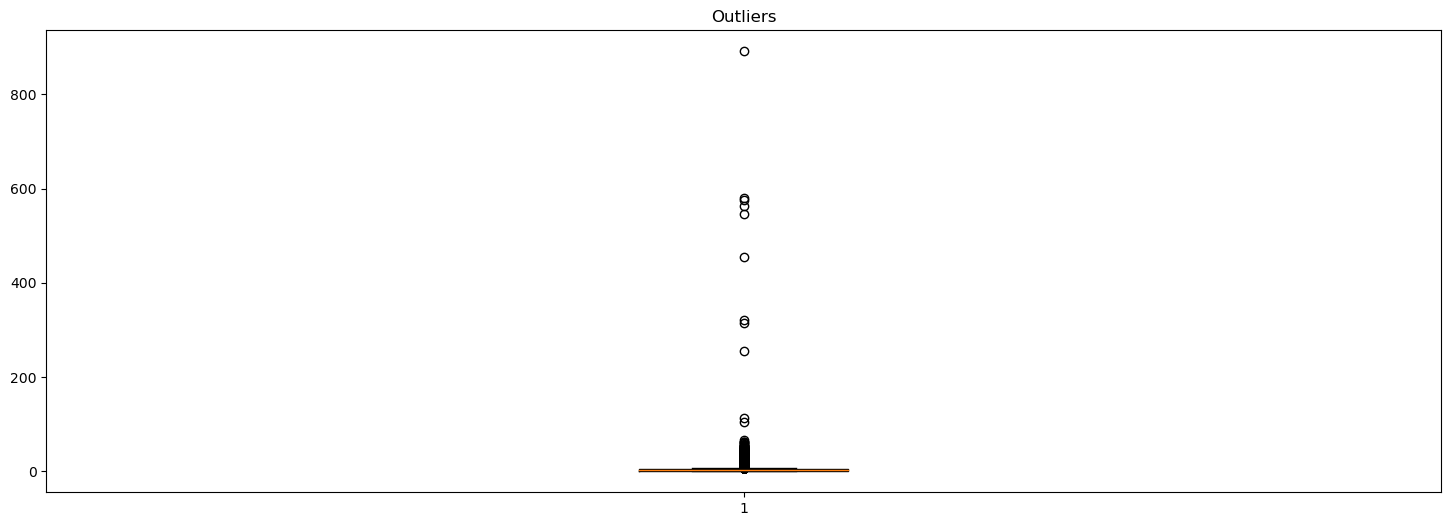

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.title("Outliers")

plt.boxplot(train['distance'])
plt.ticklabel_format(style='plain', axis='y')


plt.show()

Como esperado, encontramos mais alguns outliers a partir desses novos dados, portanto vamos remove-los, já que eles podem influenciar negativamente na precisão do nosso modelo.

In [17]:
train = train[(train.distance<200)]
train = train[(train.kph<80)]

Outros features que podem ser muito importantes para prever a duração de uma viagem de taxi em Nova Iorque, são os que estão relacionados com o tempo.
Já que como sabemos, em grande cidades o fator transito é influencia muito na duração de uma viagem e informações como epoca do ano, dia da semana e hora do dia são de grande relevancia quando queremos prever o transito.

In [18]:
train['pickup_time'] = train.pickup_datetime.dt.hour+train.pickup_datetime.dt.minute/60
train['yday'] = train.pickup_datetime.dt.dayofyear
train['wday'] = train.pickup_datetime.dt.dayofweek

test['pickup_time'] = test.pickup_datetime.dt.hour+test.pickup_datetime.dt.minute/60
test['yday'] = test.pickup_datetime.dt.dayofyear
test['wday'] = test.pickup_datetime.dt.dayofweek

train.drop(['pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True) 
test.drop(['pickup_datetime'], axis=1, inplace=True) 


Como temos temos duas colunas com dados categoricos, a coluna vendor_id e a coluda store_and_fwd_flag, precisamos lidar com eles também, já que para treinar um modelo de arvore de decisão, não devemos utilizar dados categoricos.

Para resolver esse problema, vamos utilizar a função pd.get_dummies, esse metodo cria novas colunas para cada valor único na coluna de entrada e preenche as novas colunas com 1 ou 0, dependendo da presença ou ausência daquele valor na linha correspondente.


In [19]:
temp1 = pd.get_dummies(train.store_and_fwd_flag, prefix='store_and_fwd_flag')
temp2 = pd.get_dummies(train.vendor_id, prefix='vendor_id')

temp1.columns = [col + '_' for col in temp1.columns]
temp2.columns = [col + '_' for col in temp2.columns]

train = pd.concat([train, temp1, temp2], axis=1)

train.drop(['store_and_fwd_flag', 'vendor_id'], axis=1, inplace=True)


temp3 = pd.get_dummies(test.store_and_fwd_flag, prefix='store_and_fwd_flag')
temp4 = pd.get_dummies(test.vendor_id, prefix='vendor_id')

temp3.columns = [col + '_' for col in temp1.columns]
temp4.columns = [col + '_' for col in temp2.columns]

test = pd.concat([test, temp3, temp4], axis=1)

test.drop(['store_and_fwd_flag', 'vendor_id'], axis=1, inplace=True)  

Agora para enriquecer ainda mais nossos dados, vamos tentar agrupar os dados geograficos a partir da clusterização.

Isso é interessante, porque a clusterização permite identificar padrões espaciais e agrupar locais similares. O que pode ser de grande utilidade em uma grande cidade como Nova Iorque, porque dependendo do lugar da viagem de taxi, isso pode implicar em alguma tendencia na duração da viagem.

Utilizando o Rio de Janeiro como exemplo, pense que alguem chame um taxi a partir do aeroporto galeão, é natural pensar que essa viagem tende a percorrer uma grande distancia e ter uma duração bastante elevada, por conta da posição geografica em que se encontra o aeroporto do galeão.
Em contrapartida, se alguem chama um taxi do centro da cidade, é natural que a duração dessa viagem seja mais curta, já que há grandes chances de que essa viagem ocorra entre locais pouco distantes.

A principio, a logica para a cidade de Nova Iorque deve ser a mesma.

Para realizar essa clusterização, iremos utilizar o metodo MiniBatchKmeans, que é bastante eficiente para lidar com uma grande quantidade de dados.

É importante também decidirmos o número de clusters, para isso foi utilizado a tecnica do cotovelo(elbow method), que é o metodo mais comum para isso, ele identifica o ponto onde o aumento de clusters não implica em uma melhora significativa do modelo.

In [20]:
from sklearn.cluster import MiniBatchKMeans

In [21]:
valores_k = []
inercias = []

for i in range(1, 20):
  kmeans_pickup1 = MiniBatchKMeans(n_clusters = i, batch_size=10000).fit(train[['pickup_longitude','pickup_latitude']])
  valores_k.append(i)
  inercias.append(kmeans_pickup1.inertia_)

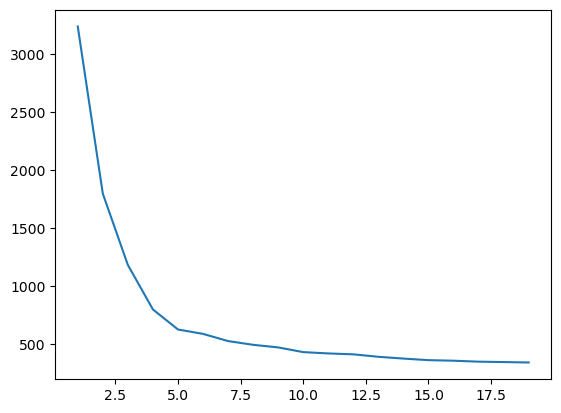

In [22]:
#vamos tentar usar o metodo do cotovelo, para identificar o numero de clusters ideal
fig, ax = plt.subplots()
ax.plot(valores_k, inercias)
plt.show() 

In [23]:
valores_k1 = []
inercias1 = []

for i in range(1, 20):
  kmeans_pickup1 = MiniBatchKMeans(n_clusters = i, batch_size=10000).fit(train[['dropoff_longitude','dropoff_latitude']])
  valores_k1.append(i)
  inercias1.append(kmeans_pickup1.inertia_)

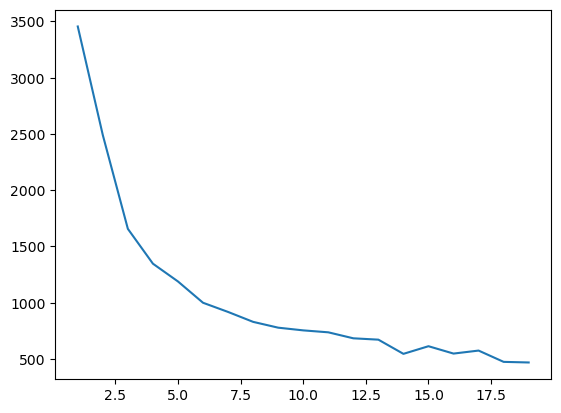

In [24]:
fig, ax = plt.subplots()
ax.plot(valores_k1, inercias1)
plt.show() 

In [25]:
kmeans = MiniBatchKMeans(n_clusters = 6, batch_size=10000).fit(train[['pickup_longitude','pickup_latitude']])
kmeans_dropoff = MiniBatchKMeans(n_clusters = 6, batch_size=10000).fit(train[['dropoff_longitude','dropoff_latitude']])

In [26]:
kmeans_test = MiniBatchKMeans(n_clusters = 6, batch_size=10000).fit(test[['pickup_longitude','pickup_latitude']])
kmeans_dropoff_test = MiniBatchKMeans(n_clusters = 6, batch_size=10000).fit(test[['dropoff_longitude','dropoff_latitude']])

In [27]:
train['pickup_kmeans'] = kmeans.predict(train[['pickup_longitude','pickup_latitude']])
train['dropoff_kmeans'] = kmeans_dropoff.predict(train[['dropoff_longitude','dropoff_latitude']])

In [28]:
test['pickup_kmeans'] = kmeans_test.predict(test[['pickup_longitude','pickup_latitude']])
test['dropoff_kmeans'] = kmeans_dropoff_test.predict(test[['dropoff_longitude','dropoff_latitude']])

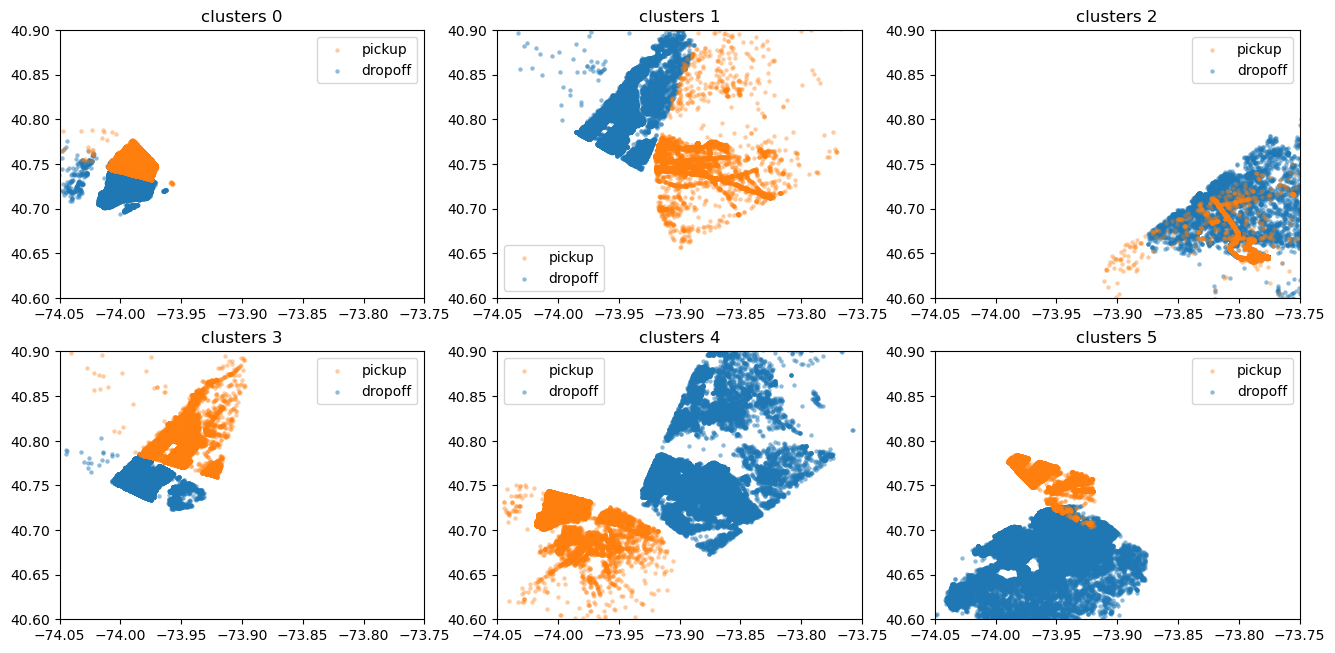

In [29]:
plt.figure(figsize=(16,16))
N = 100000
for i in range(6):
    plt.subplot(4,3,i+1)
    tmp_train = train[train.pickup_kmeans==i]
    tmp_train_mini = train[train.dropoff_kmeans==i]
    drop = plt.scatter(tmp_train_mini['dropoff_longitude'][:N], tmp_train_mini['dropoff_latitude'][:N], s=10, lw=0, alpha=0.5,label='dropoff')
    pick = plt.scatter(tmp_train['pickup_longitude'][:N], tmp_train['pickup_latitude'][:N], s=10, lw=0, alpha=0.4,label='pickup')    
    plt.xlim([-74.05,-73.75]);plt.ylim([40.6,40.9])
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)

In [30]:
train[['pickup_kmeans','trip_duration','distance']].groupby(['pickup_kmeans'], as_index = False).median() 

,pickup_kmeans,trip_duration,distance
0,0,638,1.831696
1,1,1505,9.297992
2,2,2087,18.972773
3,3,560,2.085453
4,4,694,2.339545
5,5,608,1.894683


Aqui podemos identificar alguma tendencia, já que por exemplo, podemos notar pelo grafico do cluster de pickup de número 1, que se trata do agrupamento de dados que estão em regiões mais afastadas da ilha de Manhattan, que inclusive é na região do aeroporto da cidade de Nova Iorque

E como podemos ver, a media de trip_duration e distance para esse cluster é a maior disparada, o que reforça o nosso argumento anterior.

A seguir temos dois gráficos que representam um pouco melhor como os clusters de pickup e dropoff estão distribuidos na cidades.

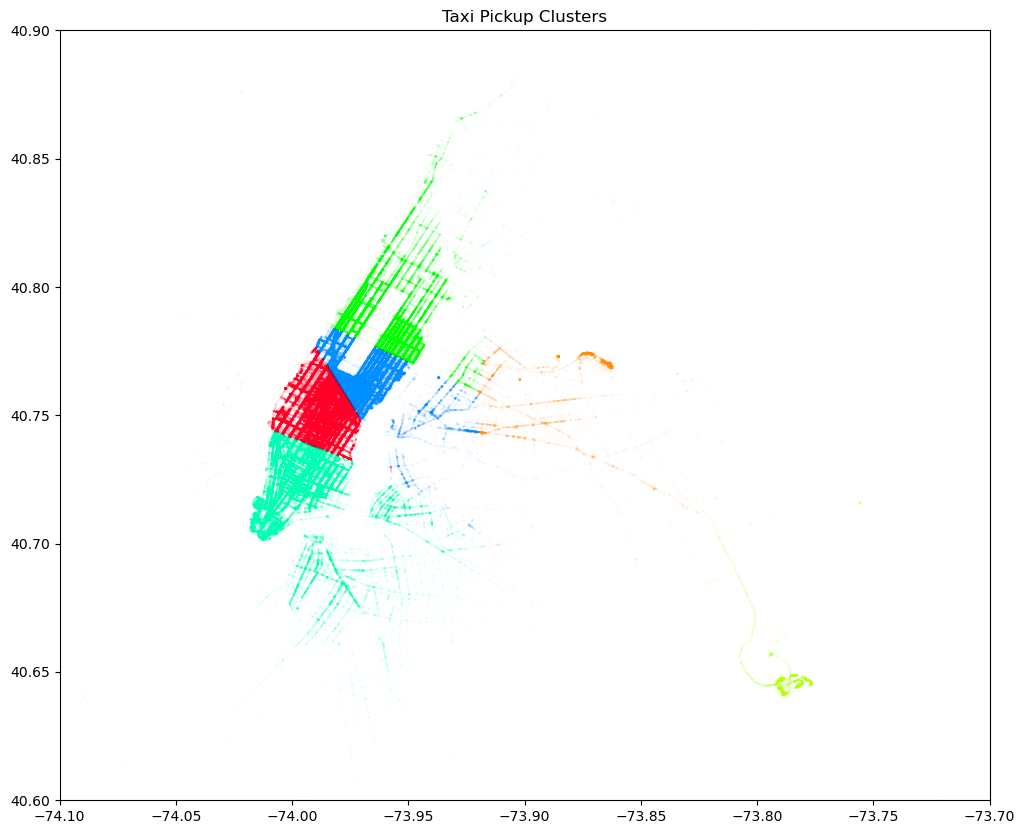

In [31]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)

cm = plt.get_cmap('gist_rainbow')

colors = [cm(2.*i/15) for i in range(6)]
colored = [colors[k] for k in train['pickup_kmeans']]

#plt.figure(figsize = (10,10))
ax.scatter(train.pickup_longitude,train.pickup_latitude,color=colored,s=0.0002,alpha=1)
plt.title('Taxi Pickup Clusters')
plt.show()

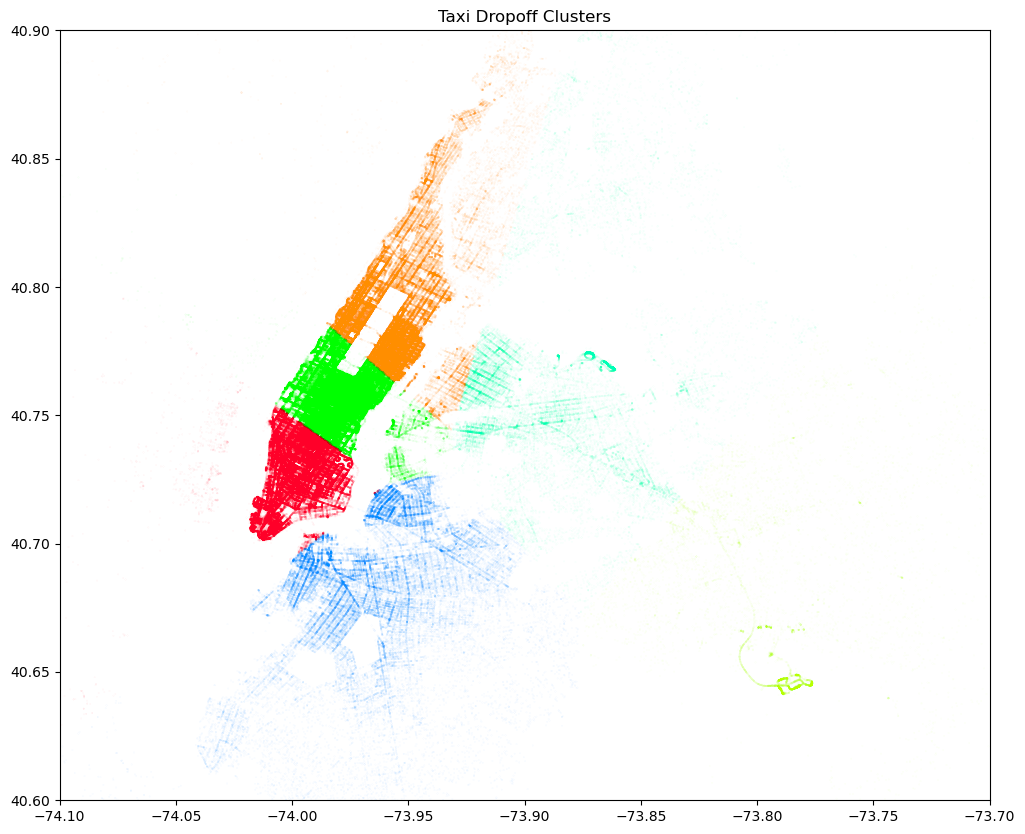

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)

cm = plt.get_cmap('gist_rainbow')

colors = [cm(2.*i/15) for i in range(6)]
colored = [colors[k] for k in train['dropoff_kmeans']]

#plt.figure(figsize = (10,10))
ax.scatter(train.dropoff_longitude,train.dropoff_latitude,color=colored,s=0.0002,alpha=1)
plt.title('Taxi Dropoff Clusters')
plt.show()

Podemos ver claramente que nossos clusters separaram a cidade de Nova Iorque em regiões, A ideia é que essa separação influencie positivamente na precisão do nosso modelo. 
Contudo, Os clusters sao dados categoricos e precisamos transforma-los em dados númericos assim como fizemos anteriormente, para que assim, possamos usar eles no nosso modelo.

Para isso, usaremos novamente o metodo pd.get_dummies.


In [33]:
dummies_pickup = pd.get_dummies(train.pickup_kmeans,prefix='pickup', prefix_sep='_') 
dummies_dropoff = pd.get_dummies(train.dropoff_kmeans,prefix='dropoff', prefix_sep='_')

In [34]:
dummies_pickup_test = pd.get_dummies(test.pickup_kmeans,prefix='pickup', prefix_sep='_') 
dummies_dropoff_test = pd.get_dummies(test.dropoff_kmeans,prefix='dropoff', prefix_sep='_')

In [35]:
train = pd.concat([train, dummies_pickup, dummies_dropoff], axis = 1)
test = pd.concat([test, dummies_pickup_test, dummies_dropoff_test], axis = 1)
train.head()

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,distance,direction,...,pickup_2,pickup_3,pickup_4,pickup_5,dropoff_0,dropoff_1,dropoff_2,dropoff_3,dropoff_4,dropoff_5
0,id2875421,1,-73.982155,40.767937,-73.964630,40.765602,455,6.122493,1.498521,99.970196,...,0,0,0,1,0,0,0,1,0,0
1,id2377394,1,-73.980415,40.738564,-73.999481,40.731152,663,6.498282,1.805507,-117.153768,...,0,0,0,0,1,0,0,0,0,0
2,id3858529,1,-73.979027,40.763939,-74.005333,40.710087,2124,7.661527,6.385098,-159.680165,...,0,0,0,1,1,0,0,0,0,0
3,id3504673,1,-74.010040,40.719971,-74.012268,40.706718,429,6.063785,1.485498,-172.737700,...,0,0,1,0,1,0,0,0,0,0
4,id2181028,1,-73.973053,40.793209,-73.972923,40.782520,435,6.077642,1.188588,179.473585,...,0,1,0,0,0,1,0,0,0,0


In [36]:
train.drop(['pickup_kmeans', 'dropoff_kmeans'], axis=1, inplace=True)
test.drop(['pickup_kmeans', 'dropoff_kmeans'], axis=1, inplace=True)
train.columns

Index(['id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'log_trip_duration', 'distance', 'direction', 'kph', 'pickup_time',
       'yday', 'wday', 'store_and_fwd_flag_N_', 'store_and_fwd_flag_Y_',
       'vendor_id_1_', 'vendor_id_2_', 'pickup_0', 'pickup_1', 'pickup_2',
       'pickup_3', 'pickup_4', 'pickup_5', 'dropoff_0', 'dropoff_1',
       'dropoff_2', 'dropoff_3', 'dropoff_4', 'dropoff_5'],
      dtype='object')

In [37]:
test.rename(columns={'store_and_fwd_flag_N__': 'store_and_fwd_flag_N_', 'store_and_fwd_flag_Y__' : 'store_and_fwd_flag_Y_' , 'vendor_id_1__' : 'vendor_id_1_', 'vendor_id_2__' : 'vendor_id_2_' }, inplace=True)

Agora de remover outliers e acrescentar features para o nosso modelo preditivo, a nossa analise exploratoria de dados terminou e podemos começar a aplicar os nossos modelos preditivos.

Começamos plotando um gráfico de correlação, para ver como nossos features se correlacionam.

é possivel notar, por exemplo, que a variavel distance se correlaciona bastante com os clusters de geolocalização e com a duração da viagem.

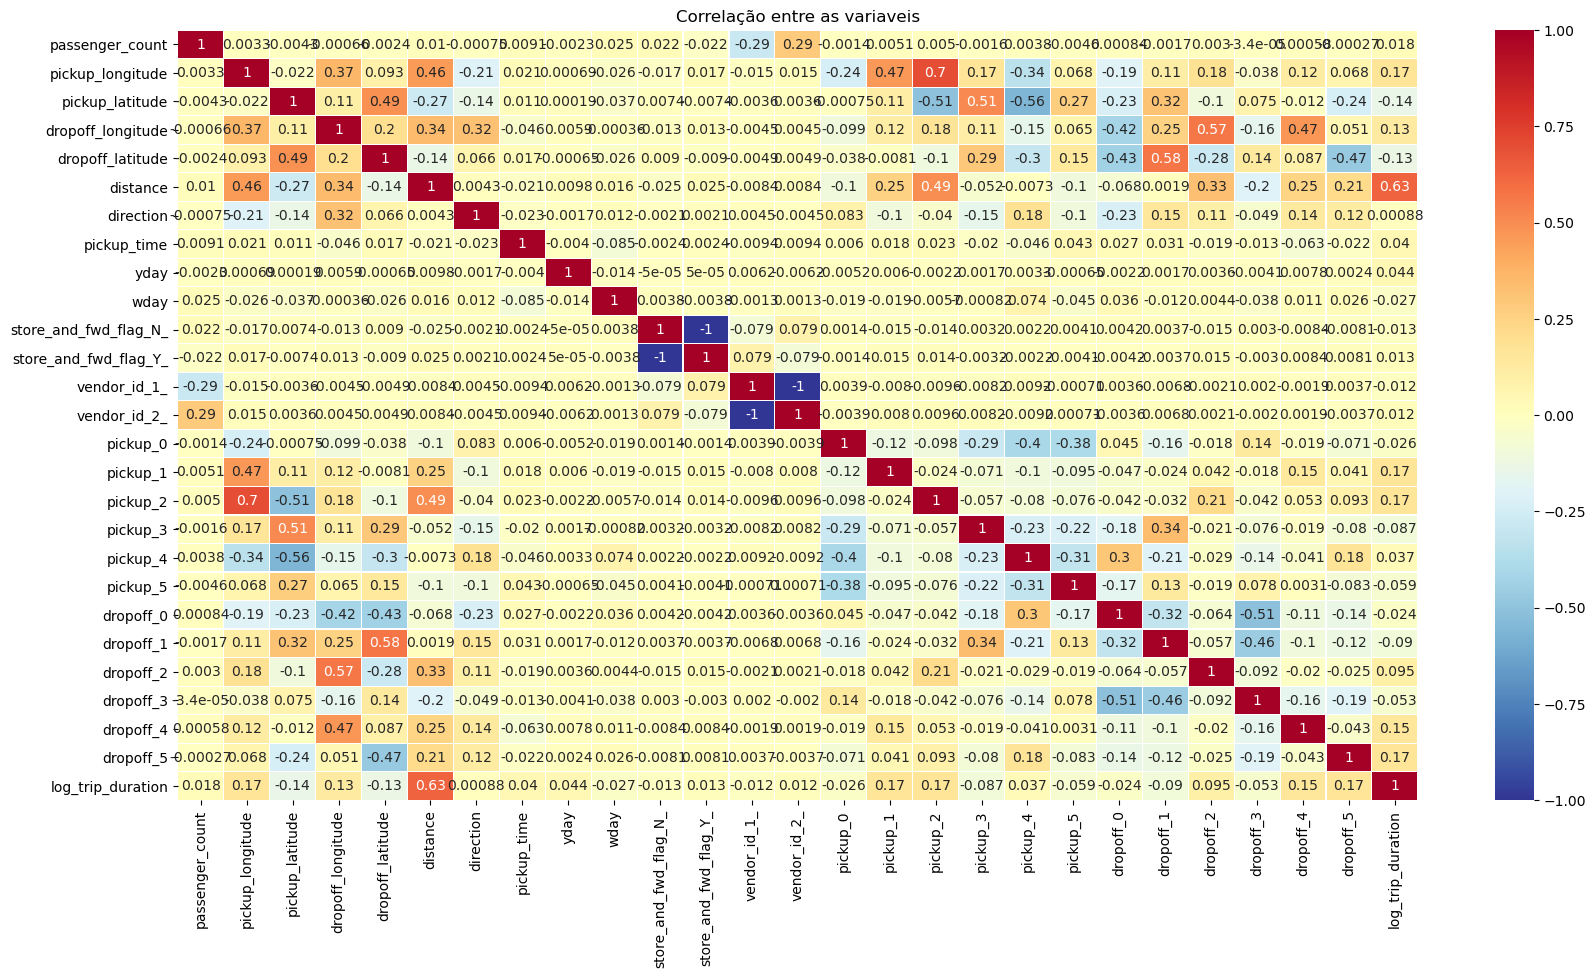

In [38]:
correlaçao = train[['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'direction','pickup_time',
       'yday', 'wday', 'store_and_fwd_flag_N_', 'store_and_fwd_flag_Y_',
       'vendor_id_1_', 'vendor_id_2_', 'pickup_0', 'pickup_1', 'pickup_2',
       'pickup_3', 'pickup_4', 'pickup_5', 'dropoff_0', 'dropoff_1',
       'dropoff_2', 'dropoff_3', 'dropoff_4', 'dropoff_5', 'log_trip_duration']]
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(data=correlaçao.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlação entre as variaveis');

Agora vamos começar a treinar modelos preditivos e fazer a avaliação de desempenho deles.

In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score


In [40]:
y = train['log_trip_duration']
X = train[['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'direction','pickup_time',
       'yday', 'wday', 'store_and_fwd_flag_N_', 'store_and_fwd_flag_Y_',
       'vendor_id_1_', 'vendor_id_2_', 'pickup_0', 'pickup_1', 'pickup_2',
       'pickup_3', 'pickup_4', 'pickup_5', 'dropoff_0', 'dropoff_1',
       'dropoff_2', 'dropoff_3', 'dropoff_4', 'dropoff_5']]

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

O primeiro modelo preditivo que iremos utilizar será o xgb.XGBRegressor, que pode ser descrito pelo ChatGPT muito melhor do que por mim:

O XGBoost Regressor é um modelo de regressão de gradient boosting de árvores de decisão desenvolvido pelo grupo XGBoost. Ele é amplamente utilizado em competições de Machine Learning e é conhecido por ser rápido, preciso e fácil de usar. O XGBoost Regressor é uma abordagem de ensino supervisionado que combina várias árvores de decisão fracas para criar uma única árvore forte capaz de realizar previsões precisas. Ele suporta uma ampla variedade de métricas de avaliação e pode ser ajustado facilmente com ajustes de hiperparâmetros. É importante fazer uma validação adequada do modelo para avaliar a performance e garantir que o modelo seja usado de forma confiável e generalizada.

Comecei optando por realizar um metodo de validação cruzada visando obter um bom resultado.

A validação cruzada é interessante porque fornece uma estimativa mais precisa e confiável da performance do modelo em comparação com a avaliação usando um único conjunto de validação. Ela ajuda a lidar com problemas de overfitting e underfitting, pois divide o conjunto de dados em vários pedaços e treina o modelo em cada um deles, o que permite que o modelo seja avaliado em diferentes conjuntos de dados e em diferentes momentos durante o treinamento. Além disso, a validação cruzada permite que você veja como o modelo se comporta em diferentes amostras de dados, o que é importante para avaliar a robustez e a generalização do modelo. Em resumo, a validação cruzada é uma técnica importante para ajudar a avaliar a performance do modelo e garantir que ele possa ser usado de forma confiável e generalizada.

Para realizar essa validação, utilizei o metodo KFold para dividir o conjunto de dados.

In [42]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=8, shuffle=True)
scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = xgb.XGBRegressor(max_depth=8, objective='reg:squarederror', eta=0.3, subsample=0.8, colsample_bytree=0.9,
                            colsample_bylevel=1, min_child_weight=10, nthread=3, eval_metric='rmse',
                            early_stopping_rounds=30)
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred = model.predict(X_val)
    scores.append(model.best_score)
    
print('Score médio:', np.mean(scores))

Score médio: 0.341028026233162


Aqui, como estamos tratando de uma competição do kaggle, utilizamos como metrica padrão o metodo RMSE(Root Mean Squared Error) que é a oficial da competição.
Quanto menor o score, melhor a performance do modelo, no nosso codigo anterior o modelo XGBRegressor foi treinado e ajustado em cada iteração, com a métrica de avaliação especificada (métrica 'rmse' e parada antecipada após 30 rodadas sem melhora). A métrica "best_score" foi salva em uma lista "scores" a cada iteração.

No final, a média dos resultados (best_score) se tornou um resumo da performance do modelo

Contudo, podemos avaliar a performance do nosso modelo utilizando outras metricas conhecidas, as definições dessas metricas vemos a seguir:

Mean Absolute Error (MAE): a média dos erros absolutos, calculada como a soma dos erros absolutos entre as previsões e os valores reais, dividido pelo número de amostras.(quanto mais proximo de 0, melhor)

Mean Absolute Percentage Error (MAPE): a média dos erros percentuais absolutos, calculada como a soma dos erros percentuais absolutos entre as previsões e os valores reais, dividido pelo número de amostras.(quanto menor, melhor)

R2 Score: também conhecido como coeficiente de determinação, o R2 Score mede o quanto o modelo explica a variação dos dados. É calculado como 1 - (erro do modelo / erro da média). O R2 Score varia entre 0 e 1, onde valores próximos de 1 indicam uma boa performance do modelo.(quanto mais proximo de 1, melhor.)


In [43]:
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("Mape", mape)
print("R2:", r2)


MAE: 0.23538099922877312
Mape 0.039375908838133813
R2: 0.7975535888924465


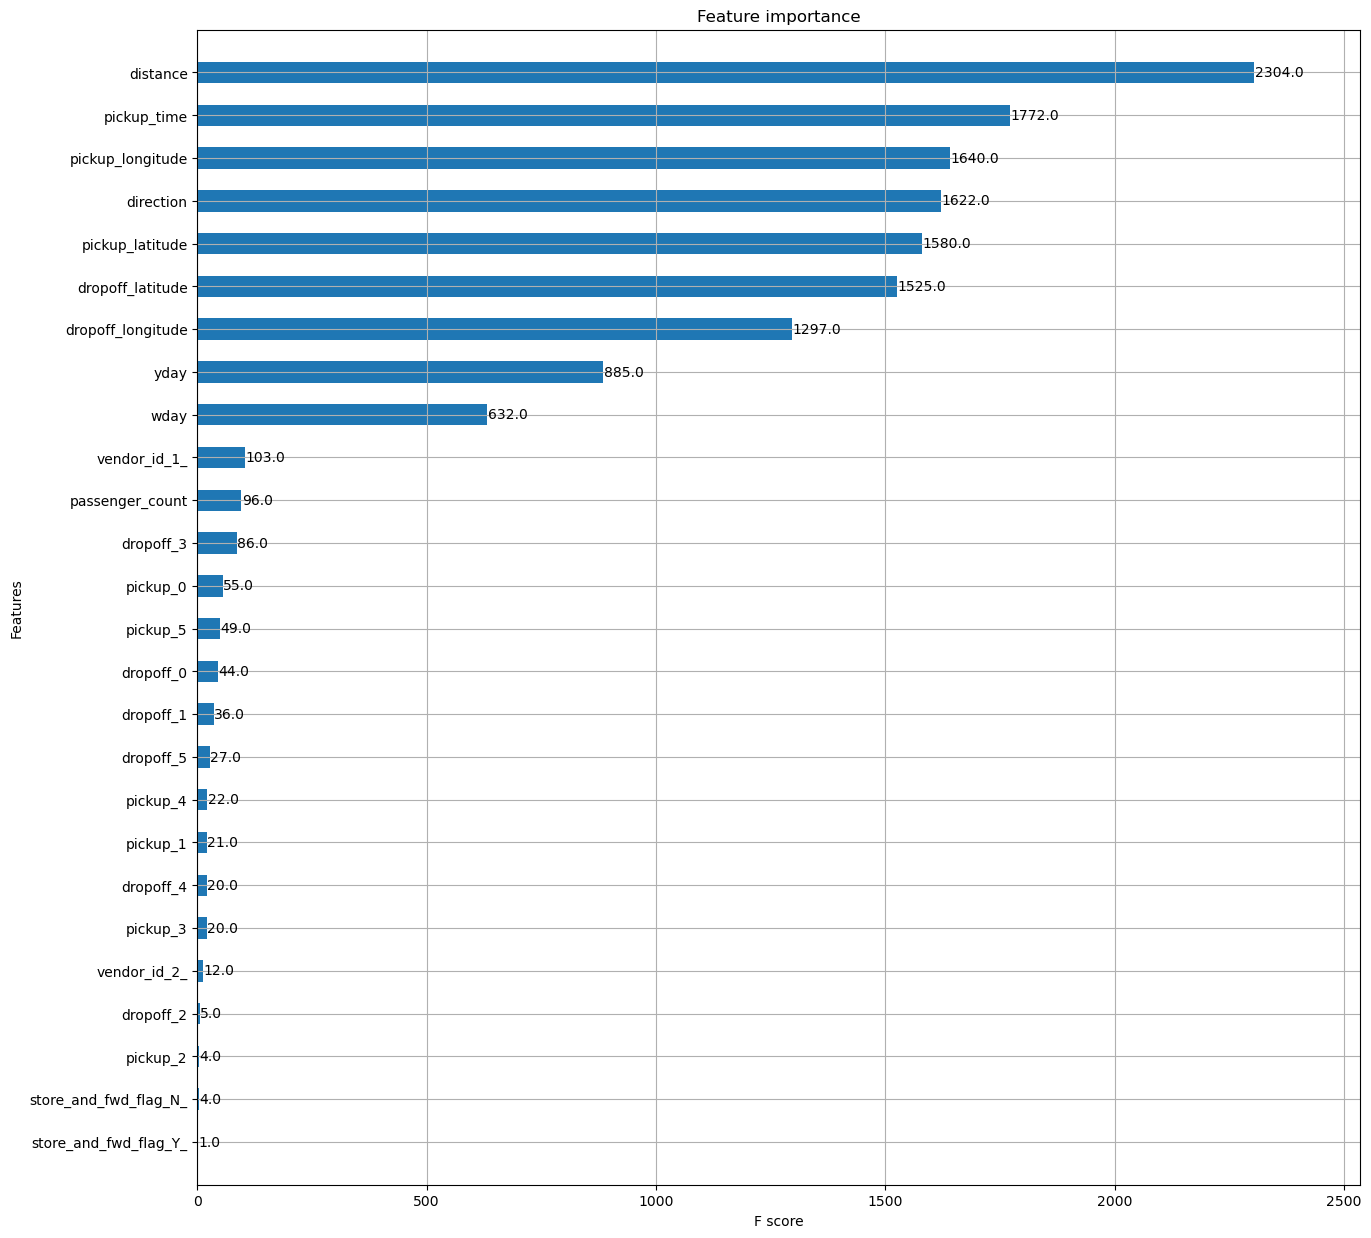

In [44]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(model,ax = axes,height =0.5)
plt.show();plt.close()

Como podemos ver, nosso modelo se saiu bem nessas metricas, alem disso, geramos um gráfico para visualizar a importância de cada feature no nosso modelo. O gráfico mostra a contribuição de cada feature em relação à variável-alvo(trip_duration) e pode ajudar a identificar as features mais importantes no modelo, o que pode ser útil para entender o comportamento do modelo e melhorar seu desempenho. Os valores de importância são calculados com base em vários métodos, como peso, ganho e cobertura, e podem ser especificados como um parâmetro na função xgb.plot_importance. 

Dito isso, podemos ver que provavelmente poderiamos ter feito uma clusterização mais eficiente, contudo a ideia por enquanto nao é ter o modelo mais eficiente, mas sim, elaborar um modelo preditivo.

Vamos agora, fazer um submit pra competição do kaggle para comparar o nosso modelo com outros modelos, afinal, toda a ideia desse dataset é voltada para isso.

In [45]:
X_test = test[['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'direction','pickup_time',
       'yday', 'wday', 'store_and_fwd_flag_N_', 'store_and_fwd_flag_Y_',
       'vendor_id_1_', 'vendor_id_2_', 'pickup_0', 'pickup_1', 'pickup_2',
       'pickup_3', 'pickup_4', 'pickup_5', 'dropoff_0', 'dropoff_1',
       'dropoff_2', 'dropoff_3', 'dropoff_4', 'dropoff_5']]

Aqui estamos desfazendo a transformação logaritmica que fizemos no inicio para poder enviar nossos dados de previsão para a competição do kaggle

In [46]:
ztest = model.predict(X_test)
Y_test = np.exp(ztest)-1

In [47]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': Y_test})
submission.to_csv("submission_xgb_cz.csv", index=False)

In [121]:
!kaggle competitions submit -c nyc-taxi-trip-duration -f submission_xgb_cz.csv -m "Message"

Successfully submitted to New York City Taxi Trip Duration



  0%|          | 0.00/12.3M [00:00<?, ?B/s]
  0%|          | 8.00k/12.3M [00:00<03:27, 62.0kB/s]
 12%|█▏        | 1.45M/12.3M [00:00<02:08, 88.3kB/s]
 51%|█████     | 6.22M/12.3M [00:00<00:50, 126kB/s] 
100%|██████████| 12.3M/12.3M [00:01<00:00, 7.99MB/s]


In [122]:
!kaggle competitions submissions -c nyc-taxi-trip-duration

fileName               date                 description  status    publicScore  privateScore  
---------------------  -------------------  -----------  --------  -----------  ------------  
submission_xgb_cz.csv  2023-02-06 12:20:18  Message      complete  0.40639      0.40324       
submission_lgbm.csv    2023-02-06 00:58:47  Message      complete  0.41085      0.40865       
submission.csv         2023-02-06 00:58:17  Message      complete  0.40270      0.40008       
submission_xgb_cz.csv  2023-02-05 23:38:18  Message      complete  0.40042      0.39816       
submission.csv         2023-02-05 23:02:37  Message      complete  0.40270      0.40008       
submission.csv         2023-02-05 16:41:25  Message      complete  0.41687      0.41475       
submission.csv         2023-02-05 16:33:28  Message      complete  0.43336      0.43099       
sub.csv                2023-02-05 16:19:31  Message      complete  0.40763      0.40604       


In [120]:
leaderboard = !kaggle competitions leaderboard --show -c nyc-taxi-trip-duration
leaderboard[0:12]

['teamId  teamName                                        submissionDate       score    ',
 '------  ----------------------------------------------  -------------------  -------  ',
 '890400  L2F                                             2017-09-15 22:40:28  0.28882  ',
 '802360  Swimming                                        2017-09-13 03:47:05  0.30566  ',
 '804203  Tomohiko Itano                                  2017-09-15 11:14:26  0.30831  ',
 '853001  sunggeun                                        2017-09-13 00:06:01  0.30837  ',
 '898714  vkadulin                                        2017-09-15 16:05:07  0.30899  ',
 '804755  HDang                                           2017-09-15 01:02:22  0.30903  ',
 '856662  felii                                           2017-09-15 14:09:09  0.30909  ',
 '804875  Thanh Tran                                      2017-09-14 05:35:00  0.30932  ',
 '812083  ♞ Schmidgital                                   2017-09-12 10:23:49  0.30961  ',

Podemos ver, que embora existam outros modelos muito mais eficientes, nós conseguimos um resultado bastante aceitavel com o nosso ultimo modelo, visto que utilizamos apenas o dataset fornecido pela competição, contudo, poderiamos enriquecer nossos dados utilizando datasets com informações sobre condições climaticas na cidade, ou até com informações geograficas mais detalhadas para cidade. Entretanto, para um primeiro momento, não vi a necessidade de enriquecer os dados dessa forma.

Vamos testar mais um modelo agora e verificar se vamos obter um resultado muito diferente.

Vamos manter os parametros e a validação cruzada, contudo, vamos utilizar o LGBMRegressor, que também faz parte de uma biblioteca de maquina baseada em arvore de decisão, contudo, seu principal atributo é que ele é rapido e considerado bastante eficiente. Portanto, Vamos testa-lo:

In [51]:
import lightgbm as lgb

In [87]:
kf = KFold(n_splits=8, shuffle=True)
scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = lgb.LGBMRegressor(max_depth=8, objective='regression', learning_rate=0.3, subsample=0.8,
                              colsample_bytree=0.9, min_child_samples=10, n_jobs=3, metric='rmse', early_stopping_round=30)
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.callback.log_evaluation(False)])
    
    y_pred = model.predict(X_val)
    scores.append(model.best_score_['valid_0']['rmse'])
    
print('Score médio:', np.mean(scores))

Score médio: 0.3479094385940307


In [ ]:
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("Mape", mape)
print("R2:", r2)


MAE: 0.24093440277213962
Mape 0.04040764257818411
R2: 0.7866260539250025


In [ ]:
ztest = model.predict(X_test)
Y_test = np.exp(ztest)-1

In [ ]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': Y_test})
submission.to_csv("submission_lgbm.csv", index=False)

In [ ]:
!kaggle competitions submit -c nyc-taxi-trip-duration -f submission_lgbm.csv -m "Message"

Successfully submitted to New York City Taxi Trip Duration



  0%|          | 0.00/17.5M [00:00<?, ?B/s]
  0%|          | 88.0k/17.5M [00:00<00:21, 849kB/s]
 13%|█▎        | 2.20M/17.5M [00:00<00:14, 1.12MB/s]
 58%|█████▊    | 10.1M/17.5M [00:00<00:04, 1.59MB/s]
100%|██████████| 17.5M/17.5M [00:02<00:00, 8.48MB/s]


In [ ]:
!kaggle competitions submissions -c nyc-taxi-trip-duration

fileName               date                 description  status    publicScore  privateScore  
---------------------  -------------------  -----------  --------  -----------  ------------  
submission_lgbm.csv    2023-02-06 00:58:47  Message      complete  0.41085      0.40865       
submission.csv         2023-02-06 00:58:17  Message      complete  0.40270      0.40008       
submission_xgb_cz.csv  2023-02-05 23:38:18  Message      complete  0.40042      0.39816       
submission.csv         2023-02-05 23:02:37  Message      complete  0.40270      0.40008       
submission.csv         2023-02-05 16:41:25  Message      complete  0.41687      0.41475       
submission.csv         2023-02-05 16:33:28  Message      complete  0.43336      0.43099       
sub.csv                2023-02-05 16:19:31  Message      complete  0.40763      0.40604       


Como podemos ver, esse modelo foi um pouco pior em todas as metricas, contudo, treinar ele levou apenas 37s e treinar o modelo pelo XGBRegressor com a validação cruzada levou quase 15 minutos.
O que demonstra que apesar de ser muito mais rapido, o modelo demonstra uma eficiencia razoavel.

Agora, por ultimo, vamos testar um modelo mais simples e ver como ele se sai em relação aos outros.
Vamos testar o modelo de Regressão Linear:

In [ ]:
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=8, shuffle=True)
scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    
print('Score médio:', np.mean(scores))

Score médio: 0.562520898874614


In [ ]:
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("Mape", mape)
print("R2:", r2)


MAE: 0.4176551935259701
Mape 0.07047127580763325
R2: 0.4488215337722825


Como podemos ver, esse modelo apresentou a pior eficiencia de todas e com uma margem significativa, o que evidencia ainda mais o poder dos modelos preditivos baseados em arvore de decisão, já que o modelo lgbm, por exemplo, apresentou resultados muito melhores e demorou apensar 7 segundo a mais para ser processado do que o modelo de regressão linear.

Com isso, talvez seja possivel afirmar, que dentro do nosso conjunto de dados, o modelo lgbm tenha sido o que melhor se encaixou, já que teve um tempo de processamento curto e resultados bastante aceitaveis, o que implica que podemos ajustar seus hyper parametros para obter resultados ainda melhores, já que estamos trabalhando bem longe do limite de processamento.